In [ ]:
from pathlib import Path
import numpy as np
from itertools import cycle
from tqdm.notebook import tqdm
import torch
from torch.optim import SGD
import argparse
import h5py
import matplotlib.pyplot as plt

from adabmDCA.utils import get_device
from adabmDCA.stats import get_freq_single_point as get_freq_single_point_cat

from annadca.binary.stats import get_freq_single_point as get_freq_single_point_bin
from annadca.dataset import DatasetBin
from annadca.dataset import DataLoader_shuffle as DataLoader
from annadca import annaRBMbin
from annadca.train import pcd

In [2]:
data_path = "/home/rosset/data/Test/MNIST/MNIST_train.dat"
weights_path = "/home/rosset/data/Test/MNIST/MNIST_train_weights.dat"
output_folder = "/home/rosset/models/MNIST"
annotations_path = "/home/rosset/data/Test/MNIST/MNIST_train_ann.csv"

hidden = 100
lr = 0.01
gibbs_steps = 10
nchains = 2000
nepochs = 10000
pseudocount = 1e-6
centered = True
seed = 0
device = "cuda"
dtype = torch.float32

In [3]:
device = get_device(device)

Running on NVIDIA GeForce RTX 2080 Ti


In [4]:
# Import dataset
dataset = DatasetBin(
    path_data=data_path,
    path_weights=weights_path,
    path_labels=annotations_path,
    device=device,
)

Dataset imported: M = 50000, L = 784, M_eff = 2.


In [5]:
rbm = annaRBMbin(
    device=device,
    dtype=dtype,
)

In [6]:
# Initialize parameters
fi_visible = get_freq_single_point_bin(
    data=dataset.data,
    weights=dataset.weights,
    pseudo_count=pseudocount,
)

fi_label = get_freq_single_point_bin(
    data=dataset.labels_one_hot,
    weights=dataset.weights,
    pseudo_count=pseudocount,
)

rbm.init_parameters(
    num_hiddens=hidden,
    num_visibles=dataset.get_num_residues(),
    num_states=dataset.get_num_states(),
    num_labels=dataset.get_num_classes(),
    frequencies_visibles=fi_visible,
    frequencies_labels=fi_label,
    std_init=1e-6,
    device=device,
    dtype=dtype,
)

In [7]:
torch.manual_seed(seed)

# Shouffle the dataset
dataset.shuffle()

In [8]:
if pseudocount is None:
    pseudocount = 1 / dataset.get_effective_size()
    print(f"Pseudocount automatically set to {pseudocount}.")

In [9]:
# Initialize the chains
chains = rbm.init_chains(
    num_samples=nchains,
)

In [10]:
# Initialize gradients for the parameters
for key, value in rbm.params.items():
    value.grad = torch.zeros_like(value)

# Select the optimizer
optimizer = SGD(rbm.params.values(), lr=lr, maximize=True)

In [11]:
# Dataloader
dataloader = DataLoader(
    dataset,
    batch_size=nchains,
    shuffle=True,
    drop_last=True,
)
# Allows to iterate indefinitely on the dataloader without worrying on the epochs
dataloader = cycle(dataloader)

In [12]:
# Training cycle
pbar = tqdm(initial=0, total=nepochs, colour="red", dynamic_ncols=True, ascii="-#")
upd = 0
with torch.no_grad():
    while upd < nepochs:
        upd += 1
        if upd % 10 == 0:
            pbar.update(10)
            
        # Get the next batch
        batch = next(dataloader)
        optimizer.zero_grad(set_to_none=False)
        chains = pcd(
            rbm=rbm,
            data_batch=batch,
            chains=chains,
            gibbs_steps=gibbs_steps,
            pseudo_count=pseudocount,
            centered=centered,
        )
        
        # Update the parameters
        optimizer.step()


  0%|          | 0/10000 [00:00<?, ?it/s]

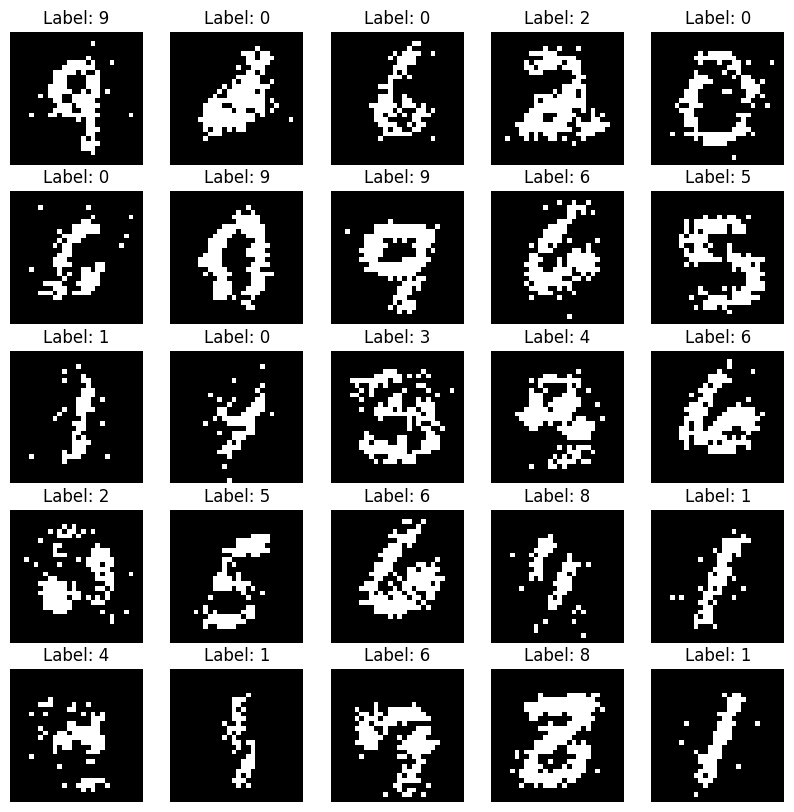

In [13]:
# Take the first 25 chains and plot the visible units in a 5x5 grid for visualizing the MNIST digits
import matplotlib.pyplot as plt

# Take the first 25 chains
mh = rbm.sample_hiddens(**chains)["hidden_mag"]
mv = rbm.sample_visibles(**chains)["visible_mag"]

#l = rbm.sample_labels(**chains)["label_mag"]
l = chains["label"]
first_25_labels = dataset.to_label(l)[:25]
first_25_chains = chains["visible"][:25].cpu().numpy()


# Plot the visible units in a 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(first_25_chains[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {first_25_labels[i]}")
    ax.axis('off')

plt.show()

### Sample from the model

In [14]:
init_chains = rbm.init_chains(num_samples=10000)
gen = rbm.sample(
    gibbs_steps=100000,
    **init_chains,
)

In [15]:
def mutual_info_labels(
    chains: dict,
) -> torch.Tensor:
    nchains = len(chains["visible"])
    
    fl = chains["label"].mean(0)
    fi = chains["visible"].mean(0)
    fil = chains["label"].t() @ chains["visible"] / nchains
    Iil = fil * (torch.log(1e-8 + fil) - torch.log(1e-8 + (fl.unsqueeze(1) @ fi.unsqueeze(0))))
    
    return Iil

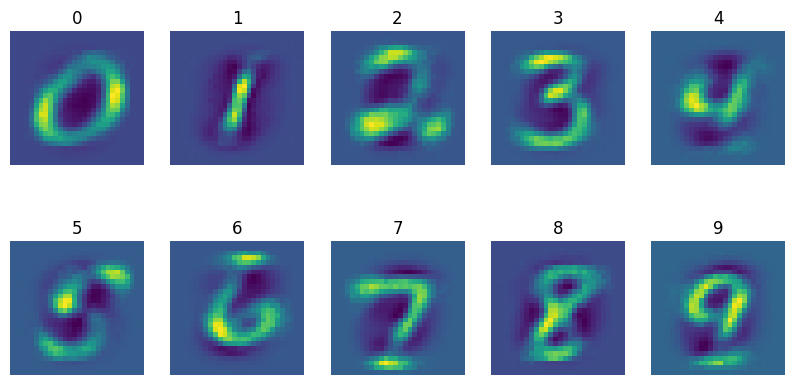

In [16]:
Iil = mutual_info_labels(gen)

# Plot an image of the mutual information between labels and chains for each label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(Iil[i].cpu().numpy().reshape(28, 28), cmap='viridis')
    ax.axis('off')
    ax.set_title(i)

### Save the model

In [19]:
fname_out = "/home/rosset/models/MNIST"
label = "annaDCA"

fname_params = Path(fname_out) / f"{label}_params.h5"
fname_chains = Path(fname_out) / f"{label}_chains.fasta"

if fname_params.exists():
    fname_params.unlink()
    
if fname_chains.exists():
    fname_chains.unlink()

rbm.save(
    filename=fname_params,
    num_updates=nepochs,
)

rbm.save_chains(
    filename=fname_chains,
    visible=chains["visible"],
    label=chains["label"],
)

### Investigate the model

In [17]:
from scipy.linalg import svd

fname_model = "/home/rosset/models/MNIST/"

def get_eigenvalues_history(filename):
    f = h5py.File(filename, 'r')
    updates = []
    eigenvalues = []
    for key in f.keys():
        if "update" in key:
            weight_matrix = f[key]["weight_matrix"][()]
            weight_matrix = weight_matrix.reshape(-1, weight_matrix.shape[-1])
            eig = svd(weight_matrix, compute_uv=False)
            eigenvalues.append(eig.reshape(*eig.shape, 1))
            updates.append(int(key.split("_")[1]))
    
    # Sort the results
    sorting = np.argsort(updates)
    updates = np.array(updates)[sorting]
    eigenvalues = np.array(np.hstack(eigenvalues).T)[sorting]
    f.close()
            
    return updates, eigenvalues